In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import math
import numpy as np

%matplotlib inline

In [2]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
def get_pca_2d(df, predict):
    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):
    pca_3d_object = prince.PCA(
        n_components=3,
        n_iter=3,
        rescale_with_mean=True,
        rescale_with_std=True,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='black',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


In [4]:
class DICE:
    '''
    DICE class turns numbers into their respective DICE embeddings
    
    Since the cosine function decreases monotonically between 0 and pi, simply employ a linear mapping
    to map distances s_n \in [0, |a-b|] to angles \theta \in [0, pi]
    '''
    def __init__(self, d=2, min_bound=0, max_bound=100, norm="l2"):
        self.d = d # By default, we build DICE-2
        self.min_bound = min_bound
        self.max_bound = max_bound
        self.norm = norm  # Restrict x and y to be of unit length
        self.M = np.random.normal(0, 1, (self.d, self.d))
        self.Q, self.R = np.linalg.qr(self.M, mode="complete")  # QR decomposition for orthonormal basis, Q
    
    def __linear_mapping(self, num):
        '''Eq. (4) from DICE'''
        norm_diff = num / abs(self.min_bound - self.max_bound)
        theta = norm_diff * math.pi
        return theta
    
    def make_dice(self, num):
        r = 1
        theta = self.__linear_mapping(num)
        if self.d == 2:
            # DICE-2
            polar_coord = np.array([r*math.cos(theta), r*math.sin(theta)])
        elif self.d > 2:
            # DICE-D
            polar_coord = np.array([math.sin(theta)**(dim-1) * math.cos(theta) if dim < self.d else math.sin(theta)**(self.d) for dim in range(1, self.d+1)])
        else:
            raise ValueError("Wrong value for `d`. `d` should be greater than or equal to 2.")
            
        dice = np.dot(self.Q, polar_coord)  # DICE-D embedding for `num`
        
        # return dice.tolist()
        return dice

In [5]:
dice = DICE(d=10, min_bound=0, max_bound=100)


In [6]:
dice.make_dice(10.12)

array([-0.17087138,  0.15716653,  0.54958029,  0.26002004, -0.48094703,
        0.36844842,  0.01061739, -0.04640639,  0.45500461,  0.0096427 ])

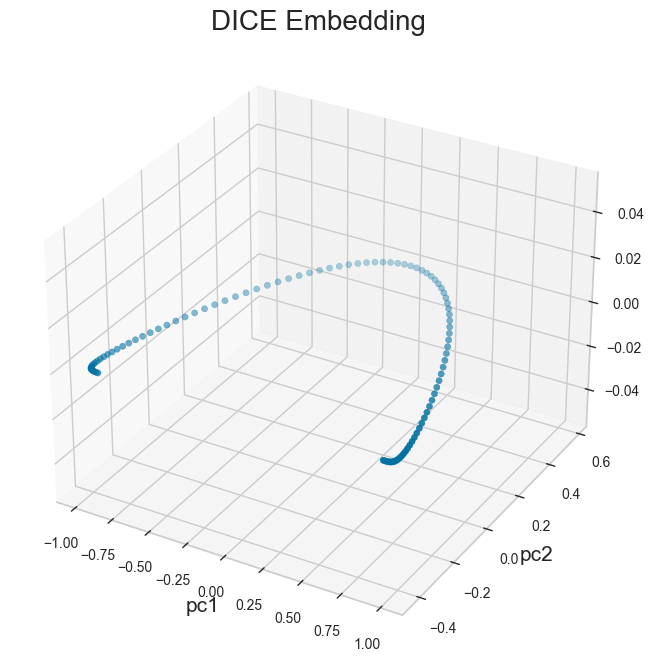

In [13]:
dice = DICE(d=3, min_bound=0, max_bound=100)

sample_nums = list(range(0, 100))

# Generate DICE-embeddings and plot them
dice_mat = []
for num in sample_nums:
    dice_mat.append(dice.make_dice(num))

dice_mat = np.array(dice_mat)

pca = PCA(n_components=2)
p_comp = pca.fit_transform(dice_mat)
p_df = pd.DataFrame(data = p_comp, columns = ["pc1", "pc2"])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("pc1", fontsize=15)
ax.set_ylabel("pc2", fontsize=15)
ax.set_title("DICE Embedding",fontsize=20)

ax.scatter(p_df["pc1"], p_df["pc2"])

In [8]:
dice = DICE(d=2, min_bound=0, max_bound=100)

sample_nums = list(range(0, 100))

# Generate DICE-embeddings and plot them
dice_mat = []
for num in sample_nums:
    dice_mat.append(dice.make_dice(num))

dice_mat = np.array(dice_mat)

pca = PCA(n_components=2)
p_comp = pca.fit_transform(dice_mat)
p_df = pd.DataFrame(data = p_comp, columns = ["pc1", "pc2"])

pca_2d_object, df_pca_2d = get_pca_2d(p_df, sample_nums)
plot_pca_2d(df_pca_2d, title = "DICE-2 Embeddings")


ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['comp1', 'comp2', 'cluster'] but received: black

In [ ]:
dice = DICE(d=3, min_bound=0, max_bound=9999)

sample_nums = list(range(0, 1000))

# Generate DICE-embeddings and plot them
dice_mat = []
for num in sample_nums:
    dice_mat.append(dice.make_dice(num))

# print(np.array(dice_mat)[:10])
dice_mat = np.array(dice_mat)

# plot 3d
pca_3d, p_df_3d = get_pca_3d(pd.DataFrame(dice_mat), sample_nums)
plot_pca_3d(p_df_3d, title = "DICE Embedding (DICE-3)")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.087970,-0.489382,-0.091139,0.062320,0.115842,0.332339,0.123408,-0.203467,-0.164460,-0.202561,-0.130670,-0.070900,-0.210507,0.144961,-0.408046,0.211046,-0.187120,-0.284041,0.029051,0.277477
1,-0.087971,-0.489384,-0.091136,0.062323,0.115846,0.332337,0.123408,-0.203458,-0.164461,-0.202565,-0.130660,-0.070896,-0.210514,0.144962,-0.408048,0.211053,-0.187116,-0.284037,0.029054,0.277477
2,-0.087972,-0.489385,-0.091134,0.062326,0.115849,0.332334,0.123408,-0.203448,-0.164463,-0.202569,-0.130651,-0.070892,-0.210520,0.144963,-0.408051,0.211059,-0.187112,-0.284033,0.029056,0.277478
3,-0.087973,-0.489386,-0.091131,0.062329,0.115853,0.332332,0.123408,-0.203438,-0.164464,-0.202573,-0.130641,-0.070888,-0.210527,0.144964,-0.408053,0.211066,-0.187108,-0.284029,0.029059,0.277478
4,-0.087974,-0.489388,-0.091129,0.062332,0.115856,0.332330,0.123409,-0.203429,-0.164465,-0.202577,-0.130631,-0.070884,-0.210534,0.144965,-0.408055,0.211072,-0.187104,-0.284025,0.029061,0.277478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,-0.007306,-0.431583,-0.165288,0.306544,0.059760,0.119217,-0.038619,0.100166,-0.336423,-0.062382,0.212370,0.216385,-0.501262,0.123175,-0.186894,0.194291,-0.275082,-0.118954,0.155495,0.030825
45207,-0.007294,-0.431577,-0.165285,0.306553,0.059753,0.119218,-0.038626,0.100174,-0.336427,-0.062375,0.212368,0.216391,-0.501263,0.123176,-0.186879,0.194284,-0.275089,-0.118958,0.155492,0.030818
45208,-0.007281,-0.431570,-0.165281,0.306562,0.059745,0.119219,-0.038634,0.100181,-0.336431,-0.062368,0.212367,0.216398,-0.501264,0.123176,-0.186863,0.194278,-0.275095,-0.118962,0.155490,0.030811
45209,-0.007269,-0.431564,-0.165278,0.306570,0.059738,0.119220,-0.038642,0.100188,-0.336435,-0.062360,0.212365,0.216405,-0.501265,0.123177,-0.186847,0.194272,-0.275102,-0.118965,0.155487,0.030804


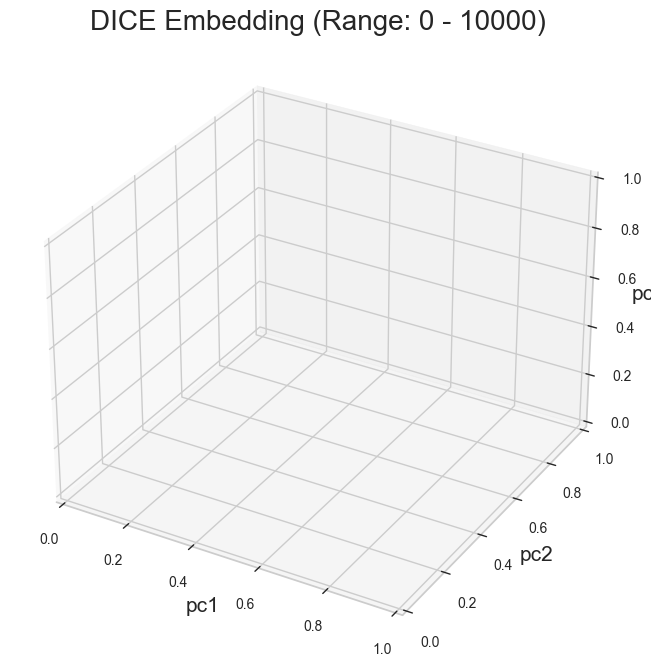

In [15]:
dice = DICE(d = 20, min_bound=-10000, max_bound=150000, norm="l2")
sample_nums = list(range(0, 45211))

# Generate DICE-embeddings and plot them
dice_mat = []
for num in sample_nums:
    dice_mat.append(dice.make_dice(num))

# print(np.array(dice_mat)[:10])
dice_mat = np.array(dice_mat)

pca = PCA(n_components=3)
p_comp = pca.fit_transform(dice_mat)
p_df = pd.DataFrame(data = p_comp, columns = ["pc1", "pc2", "pc3"])

fig = plt.figure(figsize=(8,8))
ax_3d = fig.add_subplot(111, projection="3d")
ax_3d.set_xlabel("pc1", fontsize=15)
ax_3d.set_ylabel("pc2", fontsize=15)
ax_3d.set_zlabel("pc3", fontsize=15)
ax_3d.set_title("DICE Embedding (Range: 0 - 10000)",fontsize=20)

# ax_3d.scatter(p_df["pc1"], p_df["pc2"], p_df["pc3"])

dice_df = pd.DataFrame(dice_mat)

dice_df